In [1]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.load.*weights_only=False.*")

import time

from utils import compute_pairwise_distance_metrics, compute_pairwise_inner_product_rank_correlation

import torch

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch._dynamo
torch._dynamo.config.suppress_errors = True

# First, check if CUDA is available
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:3


In [2]:
def plot_comparison_results(results, projection_dims, sparsity_levels):
    """
    Plot the comparison results between Gaussian and SJLT projection methods.

    Parameters:
    -----------
    results : dict
        Dictionary containing all results
    projection_dims : list
        List of projection dimensions tested
    sparsity_levels : list
        List of sparsity levels tested
    """
    colors = {
        "SJLT": 'dodgerblue',
        "Gaussian": 'orange'
    }

    # Reverse opacity: higher sparsity = more transparent
    min_alpha = 0.3
    max_alpha = 1.0
    sorted_sparsity = sorted(sparsity_levels)
    alphas = {
        s: max_alpha - i / max(1, len(sparsity_levels)-1) * (max_alpha - min_alpha)
        for i, s in enumerate(sorted_sparsity)
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # --- Plot 1: Computational Time ---
    ax = axes[0]
    for sparsity in sparsity_levels:
        alpha = alphas[sparsity]
        ax.plot(projection_dims, results["gaussian"]["times"][sparsity],
                marker='o', linestyle='-', linewidth=1, markersize=4,
                color=colors["Gaussian"], alpha=alpha)
        ax.plot(projection_dims, results["sjlt"]["times"][sparsity],
                marker='x', linestyle='--', linewidth=1, markersize=4,
                color=colors["SJLT"], alpha=alpha)

    ax.set_title("Computational Time by Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Time (s)")
    ax.set_xticks(projection_dims)
    ax.tick_params(axis='both', which='major')
    ax.grid(True, alpha=0.3)

    # --- Plot 2: Relative Error ---
    ax = axes[1]
    for sparsity in sparsity_levels:
        alpha = alphas[sparsity]
        ax.plot(projection_dims, results["gaussian"]["relative_errors"][sparsity],
                marker='o', linestyle='-', linewidth=1, markersize=4,
                color=colors["Gaussian"], alpha=alpha)
        ax.plot(projection_dims, results["sjlt"]["relative_errors"][sparsity],
                marker='x', linestyle='--', linewidth=1, markersize=4,
                color=colors["SJLT"], alpha=alpha)

    ax.set_title("Relative Error by Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Relative Error")
    ax.set_xticks(projection_dims)
    ax.tick_params(axis='both', which='major')
    ax.grid(True, alpha=0.3)

    # --- Unified Legend ---
    # Line style & color legend (Gaussian vs SJLT)
    method_handles = [
        Line2D([0], [0], linestyle='--', color=colors["SJLT"], marker='x',
               linewidth=1, label='Sparse'),
        Line2D([0], [0], linestyle='-', color=colors["Gaussian"], marker='o',
               linewidth=1, label='Dense (Vanilla)')
    ]

    # Opacity-based legend for sparsity levels
    sparsity_handles = [
        Line2D([0], [0], linestyle='-', color='gray', alpha=alphas[s],
               linewidth=1, label=f'Sparsity={s}')
        for s in sparsity_levels
    ]

    all_handles = method_handles + sparsity_handles
    fig.legend(handles=all_handles, loc='lower center', ncol=2 + len(sparsity_levels), bbox_to_anchor=(0.5, 0.03))

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

In [ ]:
def compare_projection_methods(projection_dims, sparsity_levels, device):
    """
    Compare Gaussian and SJLT projection methods across different sparsity levels.

    Parameters:
    -----------
    projection_dims : list
        List of projection dimensions to test
    sparsity_levels : list
        List of sparsity levels to test (0.0 to 1.0)
    device : str
        Device to use for computation ("cuda" or "cpu")

    Returns:
    --------
    dict
        Dictionary containing all results
    """
    # Results dictionaries
    results = {
        "gaussian": {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        },
        "sjlt": {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        }
    }

    # Create a batch of vectors
    batch_size = 500
    original_dim = 100000
    batch_vec = torch.randn(batch_size, original_dim, device=device)

    # Backup original vectors
    batch_vec_clone = batch_vec.clone()

    # SJLT parameters
    c = 1

    for proj_dim in projection_dims:
        print(f"Processing projection dimension: {proj_dim}")

        # For Gaussian projection
        gaussian_matrix = torch.randn(proj_dim, original_dim, device=device) / (proj_dim ** 0.5)

        # For SJLT projection
        rand_indices = torch.randint(proj_dim, (original_dim, c), device=device)
        rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1

        for sparsity in sparsity_levels:
            print(f"  Sparsity level: {sparsity}")
            batch_vec = batch_vec_clone.clone()

            # Sparsify the vectors by randomly setting a fraction (sparsity) of elements to zero
            if sparsity > 0:
                num_elements_to_drop = int(sparsity * original_dim)
                for i in range(batch_size):
                    indices_to_drop = torch.randperm(original_dim, device=device)[:num_elements_to_drop]
                    batch_vec[i, indices_to_drop] = 0

            # --- Gaussian Projection ---

            # Cold Start once to avoid overhead
            batch_vec_gaussian = batch_vec @ gaussian_matrix.T

            # Time the Gaussian projection
            torch.cuda.synchronize(device)
            start_time = time.time()

            # Perform Gaussian projection
            batch_vec_gaussian = batch_vec @ gaussian_matrix.T

            torch.cuda.synchronize(device)
            gaussian_time = time.time() - start_time

            # Calculate relative error for Gaussian
            gaussian_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_gaussian)

            # Store results
            results["gaussian"]["times"][sparsity].append(gaussian_time)
            results["gaussian"]["relative_errors"][sparsity].append(gaussian_error)

            # --- SJLT Projection ---

            # Cold Start once to avoid overhead
            batch_size, _ = batch_vec.size()

            # Get indices of elements above 0 in a single pass
            batch_idx, input_idx = torch.nonzero(torch.abs(batch_vec) > 0, as_tuple=True)
            values = batch_vec[batch_idx, input_idx]

            scaled_vals = values.repeat_interleave(c) * rand_signs[input_idx].flatten()
            final_indices = batch_idx.repeat_interleave(c) * proj_dim + rand_indices[input_idx].flatten()

            # Initialize and fill output tensor
            batch_vec_sjlt = torch.zeros(batch_size, proj_dim, device=device)
            batch_vec_sjlt.view(-1).index_add_(0, final_indices, scaled_vals)

            # Sum and normalize
            batch_vec_sjlt = batch_vec_sjlt.view(batch_size, proj_dim) / (c ** 0.5)

            # Time the SJLT projection
            torch.cuda.synchronize(device)
            start_time = time.time()

            # Perform SJLT projection
            batch_size, _ = batch_vec.size()

            # Get indices of elements above 0 in a single pass
            batch_idx, input_idx = torch.nonzero(torch.abs(batch_vec) > 0, as_tuple=True)
            values = batch_vec[batch_idx, input_idx]

            scaled_vals = values.repeat_interleave(c) * rand_signs[input_idx].flatten()
            final_indices = batch_idx.repeat_interleave(c) * proj_dim + rand_indices[input_idx].flatten()

            # Initialize and fill output tensor
            batch_vec_sjlt = torch.zeros(batch_size, proj_dim, device=device)
            batch_vec_sjlt.view(-1).index_add_(0, final_indices, scaled_vals)

            # Sum and normalize
            batch_vec_sjlt = batch_vec_sjlt.view(batch_size, proj_dim) / (c ** 0.5)

            torch.cuda.synchronize(device)
            sjlt_time = time.time() - start_time

            # Calculate relative error for SJLT
            sjlt_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_sjlt)

            # Store results
            results["sjlt"]["times"][sparsity].append(sjlt_time)
            results["sjlt"]["relative_errors"][sparsity].append(sjlt_error)

    return results

In [4]:
projection_dims = [2048, 4096, 8192]
sparsity_levels = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

results = compare_projection_methods(projection_dims, sparsity_levels, device)

Processing projection dimension: 2048
  Sparsity level: 0
  Sparsity level: 0.1
  Sparsity level: 0.3
  Sparsity level: 0.5
  Sparsity level: 0.7
  Sparsity level: 0.9
Processing projection dimension: 4096
  Sparsity level: 0
  Sparsity level: 0.1
  Sparsity level: 0.3
  Sparsity level: 0.5
  Sparsity level: 0.7
  Sparsity level: 0.9
Processing projection dimension: 8192
  Sparsity level: 0
  Sparsity level: 0.1
  Sparsity level: 0.3
  Sparsity level: 0.5
  Sparsity level: 0.7
  Sparsity level: 0.9


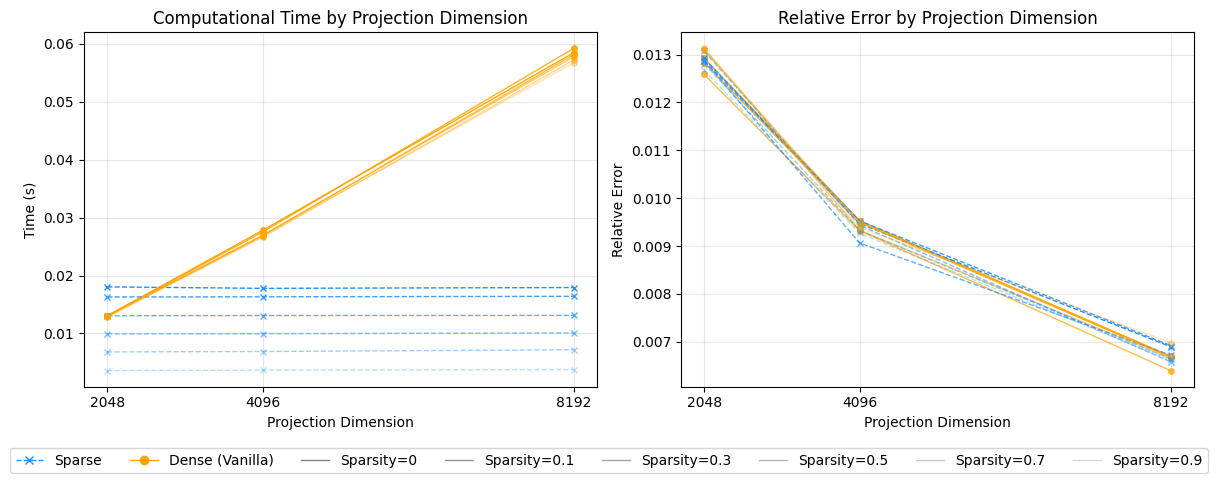

In [5]:
plot_comparison_results(results, projection_dims, sparsity_levels)